# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**План работы.**

1. Загрузить и изучить данные.
2. Выполнить предобработку данных: заполнить пропущенные значения, обработать аномалии в столбцах.
3. Подготовить выборки для изучения моделей.
4. Обучить разные модели, попробовать для каждой модели разные гиперпараметры.
5. Проанализировать время обучения, время предсказания, качество моделей.
6. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

**Описание данных**  

*Признаки*  
`DateCrawled` — дата скачивания анкеты из базы  
`VehicleType` — тип автомобильного кузова  
`RegistrationYear` — год регистрации автомобиля  
`Gearbox` — тип коробки передач  
`Power` — мощность (л.с.)  
`Model` — модель автомобиля  
`Kilometer` — пробег (км)  
`RegistrationMonth` — месяц регистрации автомобиля  
`FuelType` — тип топлива  
`Brand` — марка автомобиля  
`Repaired` — была машина в ремонте или нет  
`DateCreated` — дата создания анкеты  
`NumberOfPictures` — количество фотографий автомобиля  
`PostalCode` — почтовый индекс владельца анкеты (пользователя)  
`LastSeen` — дата последней активности пользователя  

*Целевой признак*  
`Price` — цена (евро)  

Если версия библиотеки `scikit-learn` ниже, чем 1.4, её необходимо обновить.

In [1]:
#!pip install --upgrade scikit-learn==1.4

In [2]:
import pandas as pd
import numpy as np

try:
    import matplotlib.pyplot as plt
except:
    !pip install --upgrade matplotlib==3.8.4
    import matplotlib.pyplot as plt

try:
    import seaborn as sns
except:
    !pip install --upgrade seaborn==0.13
    import seaborn as sns


import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

try:
    import lightgbm
except:
    !pip install lightgbm
    import lightgbm

from lightgbm import LGBMRegressor

try:
    import phik
except:
    !pip install phik
    import phik

from phik.report import plot_correlation_matrix

import time
import warnings
warnings.simplefilter(action='ignore')

## Подготовка данных
### Загрузка и изучение данных

In [3]:
# Формула для оптимизации кода вывода первичной информации
def information(dataset):
    display(dataset.head())
    display()
    display(dataset.info())

In [4]:
# Загрузим данные, сохраним их в датафрейм `autos`,
# применим параметр `parse_dates`, чтобы привести даты к формату `datetime`
try:
    autos = pd.read_csv(
        '/datasets/autos.csv',
        parse_dates=['DateCrawled', 'DateCreated', 'LastSeen']
    )
except:
    autos = pd.read_csv(
        'https://code.s3.yandex.net/datasets/autos.csv',
        parse_dates=['DateCrawled', 'DateCreated', 'LastSeen']
    )

# Изучим общую информацию о датафрейме
information(autos)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

None

Датафрейм содержит 354369 строк и 16 столбцов. Названия столбцов корректные. Типы данных корректные.   
Если судить по общей информации, в некоторых столбцах имеются пропущенные значения.

### Предобработка данных

In [5]:
# Проверим данные на пропуски
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропущенные значения имеются в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`. Предположить, какие значения должны быть в этих столбцах, мы не можем, поэтому заполним эти пропуски значением `unknown`.

In [6]:
autos = autos.fillna(value='unknown')

# Проверим
information(autos)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        354369 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            354369 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              354369 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           354369 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           354369 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

None

Проверим датафрейм на наличие дубликатов.

In [7]:
# Ищем явные дубликаты
autos.duplicated().sum()

4

In [8]:
# Удаляем явные дубликаты
autos = autos.drop_duplicates()

# Проверим
autos.duplicated().sum()

0

In [9]:
# Ищем неявные дубликаты, выведем уникальные значения в категориальных столбцах
autos_cat = autos.select_dtypes(include='object')
for column in autos_cat.columns:
    print(f'Уникальные значения в столбце "{column}": {autos_cat[column].unique()}')
    print('-' * 40)

Уникальные значения в столбце "VehicleType": ['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']
----------------------------------------
Уникальные значения в столбце "Gearbox": ['manual' 'auto' 'unknown']
----------------------------------------
Уникальные значения в столбце "Model": ['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan

По всей видимости, категориальные данные заполнялись по выпадающим спискам, поэтому ошибок нет. Столбец `Repaired` должен иметь булевы значения. Однако пропущенные значения нарушили этот тип значений. Возможно, пропущенные значения появились из-за нежелания указывать, что машина была в ремонте, то есть были поломки или повреждения. Факт, что машине не требовался ремонт, обычно увеличивает цену, и владельцы его обязательно указывают. Поэтому предположим, что пропущенные значения, которые теперь имеют значение `unknown`, в столбце `Repaired` должны иметь значение `yes`. Заменим значения в столбце.

In [10]:
autos['Repaired'] = autos['Repaired'].replace('unknown', 'yes')

# Проверим
print(f"Уникальные значения в столбце 'Repaired': {autos['Repaired'].unique()}" )

Уникальные значения в столбце 'Repaired': ['yes' 'no']


### Исследовательский анализ данных

In [11]:
# Напишем функцию построения графиков для количественных признаков
def graphics_num(characteristic, feature_title):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    fig.suptitle(feature_title)
    sns.histplot(data=autos, x=characteristic, bins=30, ax=axes[0])
    axes[0].set_title('Гистограмма распределения')
    sns.boxplot(data=autos, y=characteristic, ax=axes[1])
    axes[1].set_title('Разброс значений признаков')
    plt.show()
    print('Описание данных')
    print(autos[characteristic].describe().round(2))

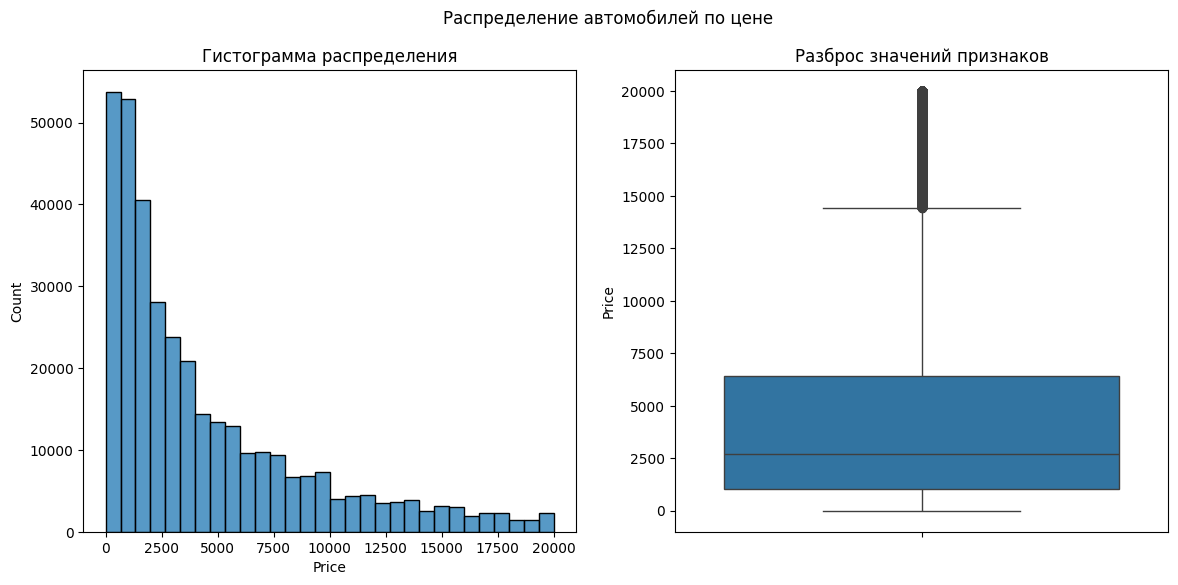

Описание данных
count    354365.00
mean       4416.68
std        4514.18
min           0.00
25%        1050.00
50%        2700.00
75%        6400.00
max       20000.00
Name: Price, dtype: float64


In [12]:
# Построим графики распределения автомобилей по цене
graphics_num('Price', 'Распределение автомобилей по цене')

Средняя цена автомобилей, судя по графику и описанию данных, бывает нулевая. Эти значения аномальные, их нужно удалить. Кроме того, примем за неправдоподобные значения цены менее 100 евро.

In [13]:
autos = autos[autos.Price > 100]
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340020 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        340020 non-null  datetime64[ns]
 1   Price              340020 non-null  int64         
 2   VehicleType        340020 non-null  object        
 3   RegistrationYear   340020 non-null  int64         
 4   Gearbox            340020 non-null  object        
 5   Power              340020 non-null  int64         
 6   Model              340020 non-null  object        
 7   Kilometer          340020 non-null  int64         
 8   RegistrationMonth  340020 non-null  int64         
 9   FuelType           340020 non-null  object        
 10  Brand              340020 non-null  object        
 11  Repaired           340020 non-null  object        
 12  DateCreated        340020 non-null  datetime64[ns]
 13  NumberOfPictures   340020 non-null  int64   

Осталось 340020 строки. Построим графики заново.

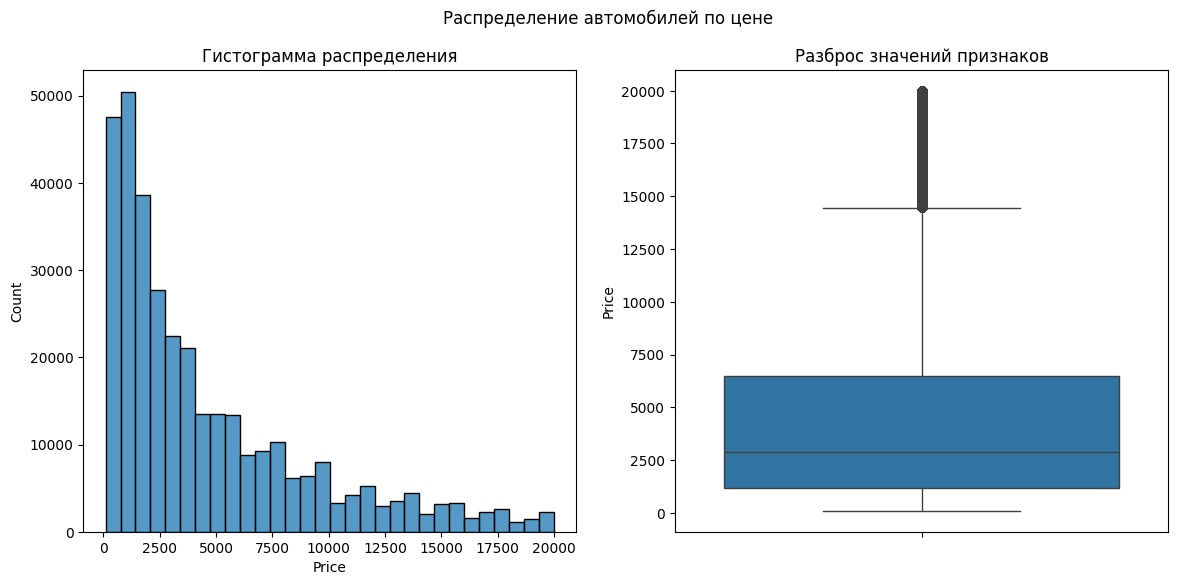

Описание данных
count    340020.00
mean       4602.50
std        4514.92
min         101.00
25%        1200.00
50%        2900.00
75%        6500.00
max       20000.00
Name: Price, dtype: float64


In [14]:
# Повторно построим графики распределения автомобилей по цене
graphics_num('Price', 'Распределение автомобилей по цене')

Получаем, что средняя цена автомобиля составляет около 4600 евро, медианная цена 2900 евро. Половина автомобилей имеет цену в диапазоне от 1200 до 6500 евро. Разброс цен на автомобили большой (стандартное отклонение превышает среднее значение).

In [15]:
# Напишем функцию построения столбчатых диаграмм для категориальных признаков
def graphic_cat(charakteristic, graphic_name, label_name):
    fig = plt.figure(figsize=(6, 4))
    sns.countplot(data=autos, y=charakteristic)
    plt.xlabel('Количество')
    plt.ylabel(label_name)
    plt.grid()
    plt.show()
    print(autos[charakteristic].value_counts(normalize=True))

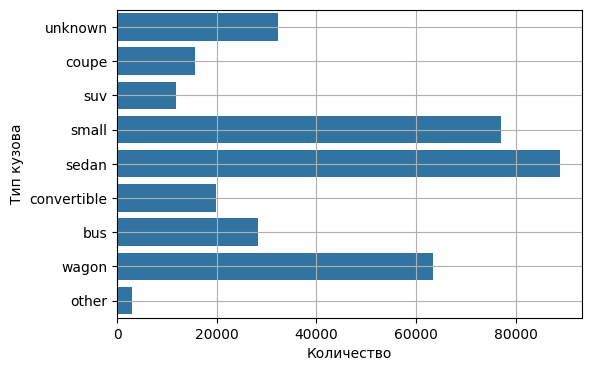

sedan          0.261646
small          0.226540
wagon          0.186410
unknown        0.094850
bus            0.083101
convertible    0.058252
coupe          0.045680
suv            0.034580
other          0.008941
Name: VehicleType, dtype: float64


In [16]:
# Построим столбчатую диаграмму распределения автомобилей по типу кузова
graphic_cat('VehicleType', 'Распределение автомобилей по типу кузова', 'Тип кузова')

Самые популярные типы кузова `sedan` (26,2 %), `small` (22.7 %), `wagon` (18.6 %).

In [17]:
# Проверим, какие значения есть в столбце `RegistrationYear`
count_year = autos['RegistrationYear'].value_counts()
count_year

2000    22496
1999    21779
2005    21341
2006    19639
2001    19549
        ...  
1946        1
1949        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 136, dtype: int64

In [18]:
# Проверим, какие максимальные и минимальные значения года
# есть в столбце `DateCrawled` (дата скачивания анкеты из базы)
print('Max ', pd.DatetimeIndex(autos['DateCrawled']).year.min())
print('Min ', pd.DatetimeIndex(autos['DateCrawled']).year.min())

Max  2016
Min  2016


Год регистрации автомобиля не может быть больше даты выгрузки анкеты, поэтому данные, где значения в столбце `RegistrationYear` превышают значение `2016`, нужно удалить.

In [19]:
autos = autos.query('RegistrationYear <= 2016')

# Проверим, сколько строк осталось
print(len(autos))

326347


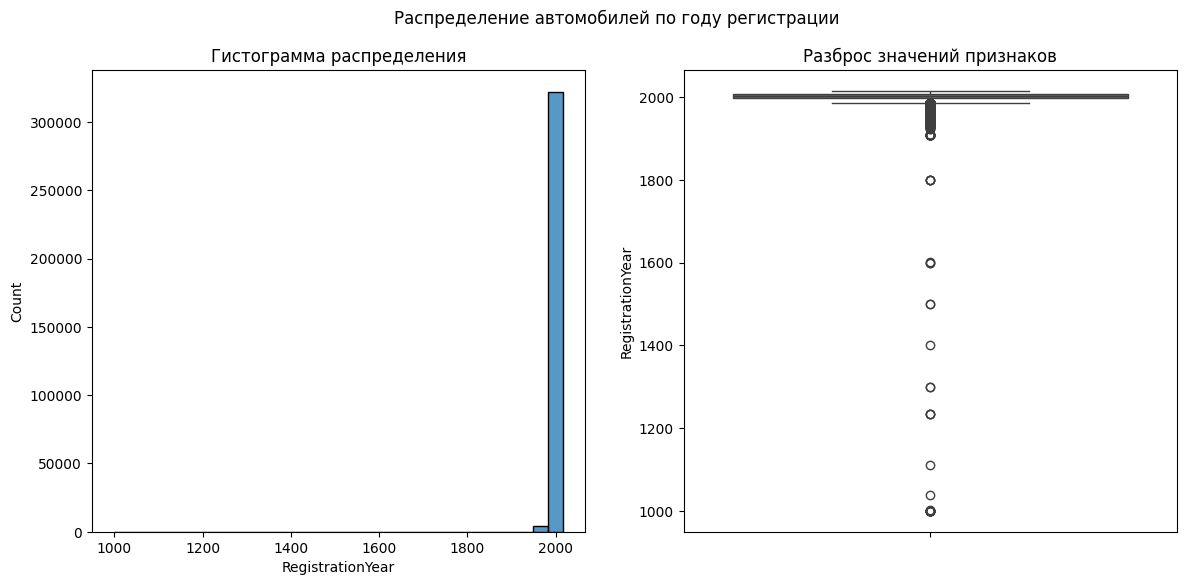

Описание данных
count    326347.00
mean       2002.54
std          11.67
min        1000.00
25%        1999.00
50%        2003.00
75%        2007.00
max        2016.00
Name: RegistrationYear, dtype: float64


In [20]:
# Построим графики распределения автомобилей по году регистрации
graphics_num('RegistrationYear', 'Распределение автомобилей по году регистрации')

"Ящик с усами" и описание данных показывают, что значения года регистрации автомобиля меньше `1999` являются аномальными. Их также необходимо удалить.

In [21]:
autos = autos.query('RegistrationYear >= 1999')

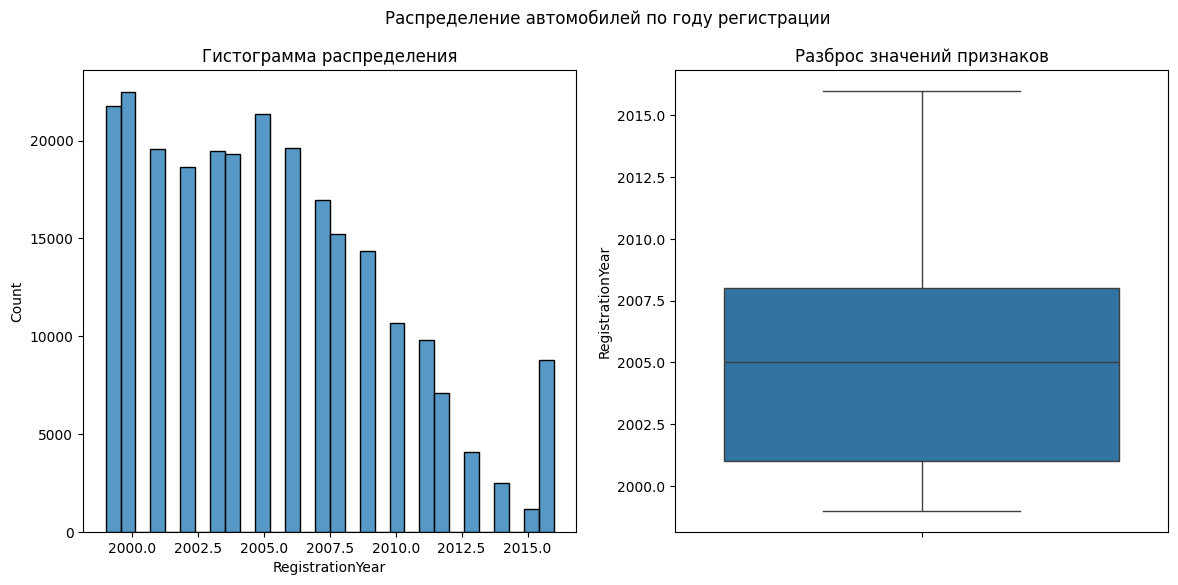

Описание данных
count    252854.00
mean       2005.18
std           4.44
min        1999.00
25%        2001.00
50%        2005.00
75%        2008.00
max        2016.00
Name: RegistrationYear, dtype: float64


In [22]:
# Построим снова графики распределения автомобилей по году регистрации
graphics_num('RegistrationYear', 'Распределение автомобилей по году регистрации')

In [23]:
# Проверим
print(f'Осталось строк: {len(autos)}')
print(f'Минимальное значение в столбце "RegistrationYear": {autos["RegistrationYear"].min()}')
print(f'Максимальное значение в столбце "RegistrationYear": {autos["RegistrationYear"].max()}')

Осталось строк: 252854
Минимальное значение в столбце "RegistrationYear": 1999
Максимальное значение в столбце "RegistrationYear": 2016


Осталось 252854 строки. Год регистрации автомобилей в данных с 1999 по 2016. Половина автомобилей зарегистрированы с 2001 по 2008 годы. Разброс автомобилей по году регистрации небольшой. Данные очищены от аномальных значений.

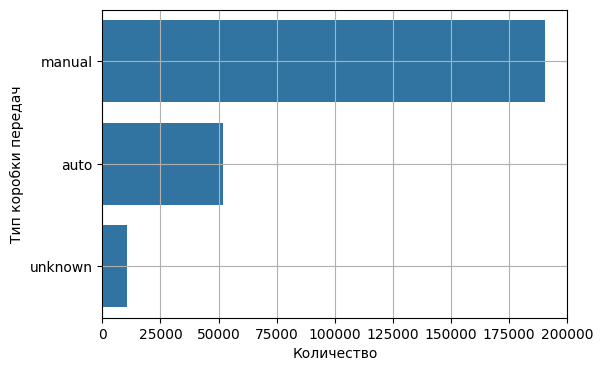

manual     0.753360
auto       0.204671
unknown    0.041969
Name: Gearbox, dtype: float64


In [24]:
# Построим графики распределения автомобилей типу коробки передач
graphic_cat('Gearbox', 'Распределение автомобилей по типу коробки передач', 'Тип коробки передач')

Более 75 % автомобилей имеют механическую коробку передач, около 20 % - автоматическую.

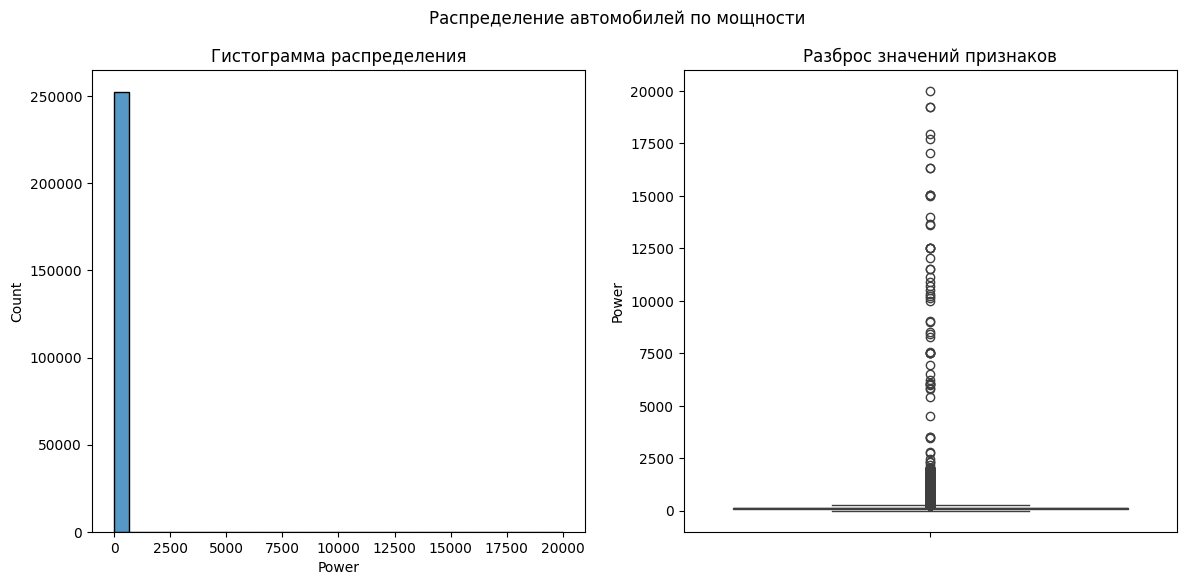

Описание данных
count    252854.00
mean        117.18
std         180.31
min           0.00
25%          75.00
50%         110.00
75%         150.00
max       20000.00
Name: Power, dtype: float64


In [25]:
# Построим графики распределения автомобилей по мощности
graphics_num('Power', 'Распределение автомобилей по мощности')

In [26]:
# Удалим строки с аномальными значениями мощности, менее 40 л.с. и более 600 л.с.
autos = autos.loc[(autos['Power'] > 40) & (autos['Power'] < 500)]
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230494 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        230494 non-null  datetime64[ns]
 1   Price              230494 non-null  int64         
 2   VehicleType        230494 non-null  object        
 3   RegistrationYear   230494 non-null  int64         
 4   Gearbox            230494 non-null  object        
 5   Power              230494 non-null  int64         
 6   Model              230494 non-null  object        
 7   Kilometer          230494 non-null  int64         
 8   RegistrationMonth  230494 non-null  int64         
 9   FuelType           230494 non-null  object        
 10  Brand              230494 non-null  object        
 11  Repaired           230494 non-null  object        
 12  DateCreated        230494 non-null  datetime64[ns]
 13  NumberOfPictures   230494 non-null  int64   

Осталось 230494 строки.

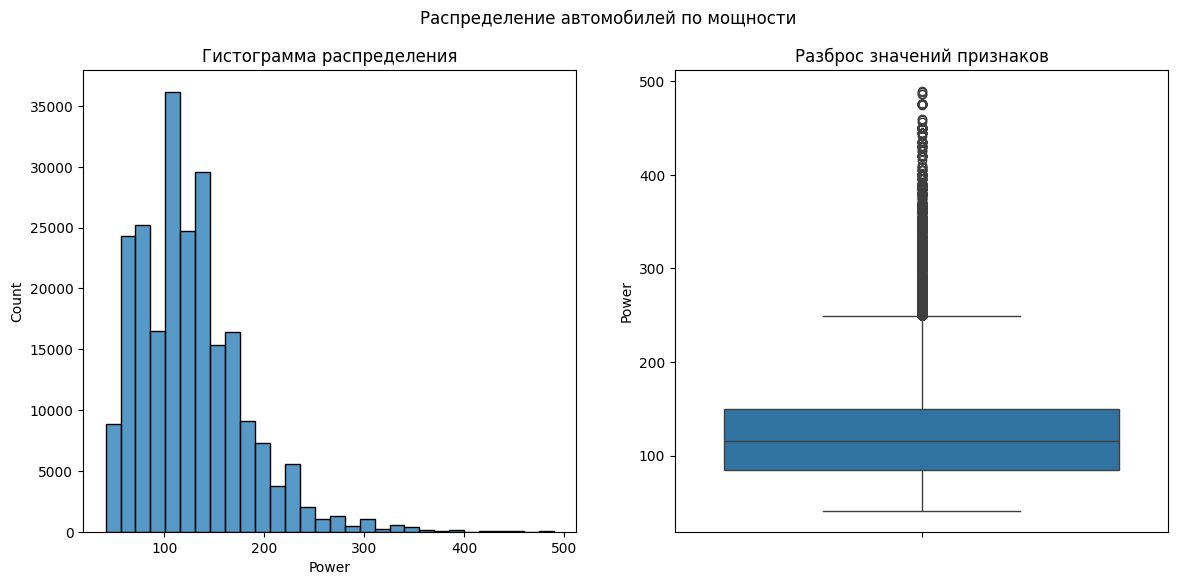

Описание данных
count    230494.00
mean        124.81
std          53.52
min          41.00
25%          84.00
50%         116.00
75%         150.00
max         490.00
Name: Power, dtype: float64


In [27]:
# Построим ещё раз графики распределения автомобилей по мощности
graphics_num('Power', 'Распределение автомобилей по мощности')

Среднее значение мощности автомобилей около 124 л.с., медианное значение 116 л.с. Половина автомобилей имеет мощность от 84 до 150 л.с. Разброс автомобилей по мощности достаточно большой.

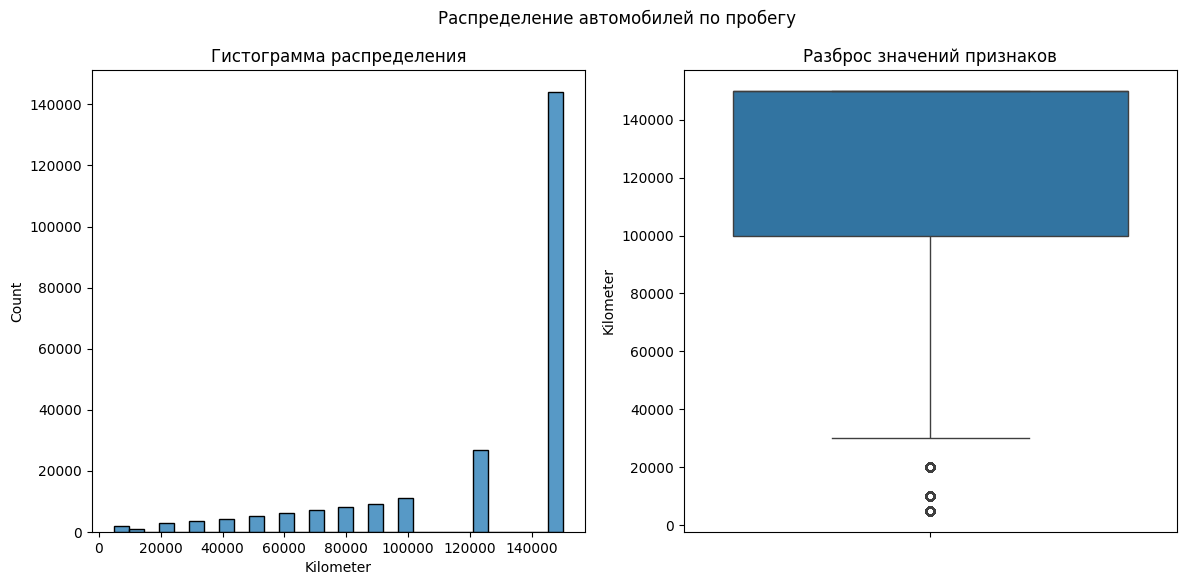

Описание данных
count    230494.00
mean     125819.87
std       37806.23
min        5000.00
25%      100000.00
50%      150000.00
75%      150000.00
max      150000.00
Name: Kilometer, dtype: float64


In [28]:
# Построим графики распределения автомобилей по пробегу
graphics_num('Kilometer', 'Распределение автомобилей по пробегу')

Автомобилей с небольшим пробегом очень мало, большинство автомобилей имеет пробег более 100 тысяч километров.

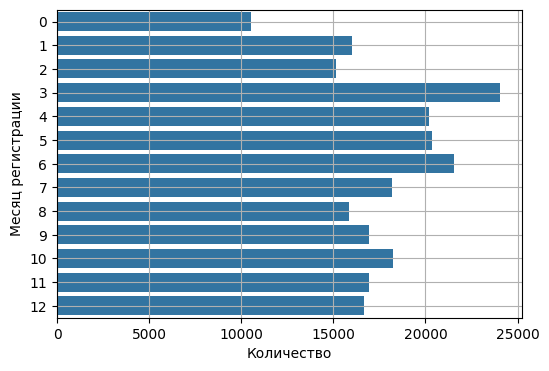

3     0.104289
6     0.093538
5     0.088245
4     0.087564
10    0.079013
7     0.078813
9     0.073494
11    0.073364
12    0.072267
1     0.069355
8     0.068687
2     0.065754
0     0.045615
Name: RegistrationMonth, dtype: float64


In [29]:
# Построим столбчатую диаграмму распределения автомобилей по месяцу регистрации
graphic_cat('RegistrationMonth', 'Распределение автомобилей по месяцу регистрации', 'Месяц регистрации')

Разница числа автомобилей по месяцам регистрации небольшая, но всё же чаще регистрируются автомобили с марта по июль.

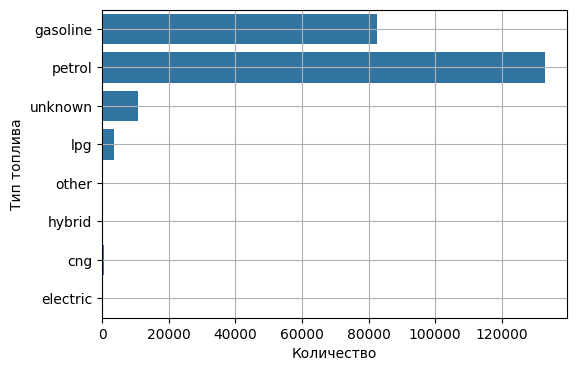

petrol      0.577100
gasoline    0.358387
unknown     0.045984
lpg         0.015454
cng         0.001970
hybrid      0.000842
other       0.000139
electric    0.000126
Name: FuelType, dtype: float64


In [30]:
# Построим столбчатую диаграмму распределения автомобилей по типу топлива
graphic_cat('FuelType', 'Распределение автомобилей по типу топлива', 'Тип топлива')

Более 57 % автомобилей имеют тип топлива бензин, более 35 % - газ. Остальные типы топлива применяются в очень небольшом числе автомобилей.

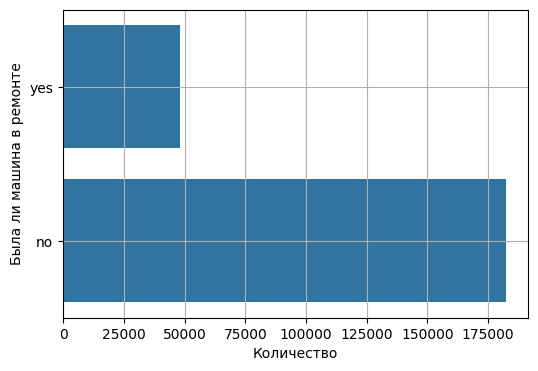

no     0.791105
yes    0.208895
Name: Repaired, dtype: float64


In [31]:
# Построим столбчатую диаграмму распределения автомобилей по факту ремонта
graphic_cat('Repaired', 'Распределение автомобилей по факту ремонта', 'Была ли машина в ремонте')

Более 79 % машин не были в ремонте, более 20 % были.

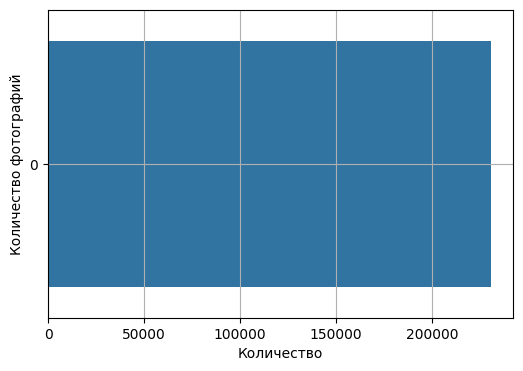

0    1.0
Name: NumberOfPictures, dtype: float64


In [32]:
# Построим столбчатую диаграмму распределения автомобилей по количеству фотографий
graphic_cat('NumberOfPictures', 'Распределение автомобилей по количеству фотографий', 'Количество фотографий')

Столбец `NumberOfPictures` неинформативный, данных в нём не содержится, его нужно удалить. Кроме того, для нашего дальнейшего исследования не несут информации столбцы `DateCrawled`, `DateCreated`, `PostalCode`, `LastSeen`. Удалим все эти столбцы.

In [33]:
# Удаляем столбцы
autos_new = autos.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

# Сбрасываем индексы
autos_new.reset_index(drop= True , inplace= True )

# Проверим готовый датафрейм
information(autos_new)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,yes
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
4,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230494 entries, 0 to 230493
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              230494 non-null  int64 
 1   VehicleType        230494 non-null  object
 2   RegistrationYear   230494 non-null  int64 
 3   Gearbox            230494 non-null  object
 4   Power              230494 non-null  int64 
 5   Model              230494 non-null  object
 6   Kilometer          230494 non-null  int64 
 7   RegistrationMonth  230494 non-null  int64 
 8   FuelType           230494 non-null  object
 9   Brand              230494 non-null  object
 10  Repaired           230494 non-null  object
dtypes: int64(5), object(6)
memory usage: 19.3+ MB


None

В датафрейме осталось 230494 строки. Выполним корреляционный анализ признаков.

In [34]:
# Построим матрицу корреляции `phik`
# Создадим список с наименованиями непрерывных признаков
interval_cols = ['Price', 'Power', 'Kilometer']

# Cчитаем корреляции
phik_overview = autos_new.phik_matrix(interval_cols=interval_cols)

# Выведем размерность матрицы корреляции
print(phik_overview.shape)

(11, 11)


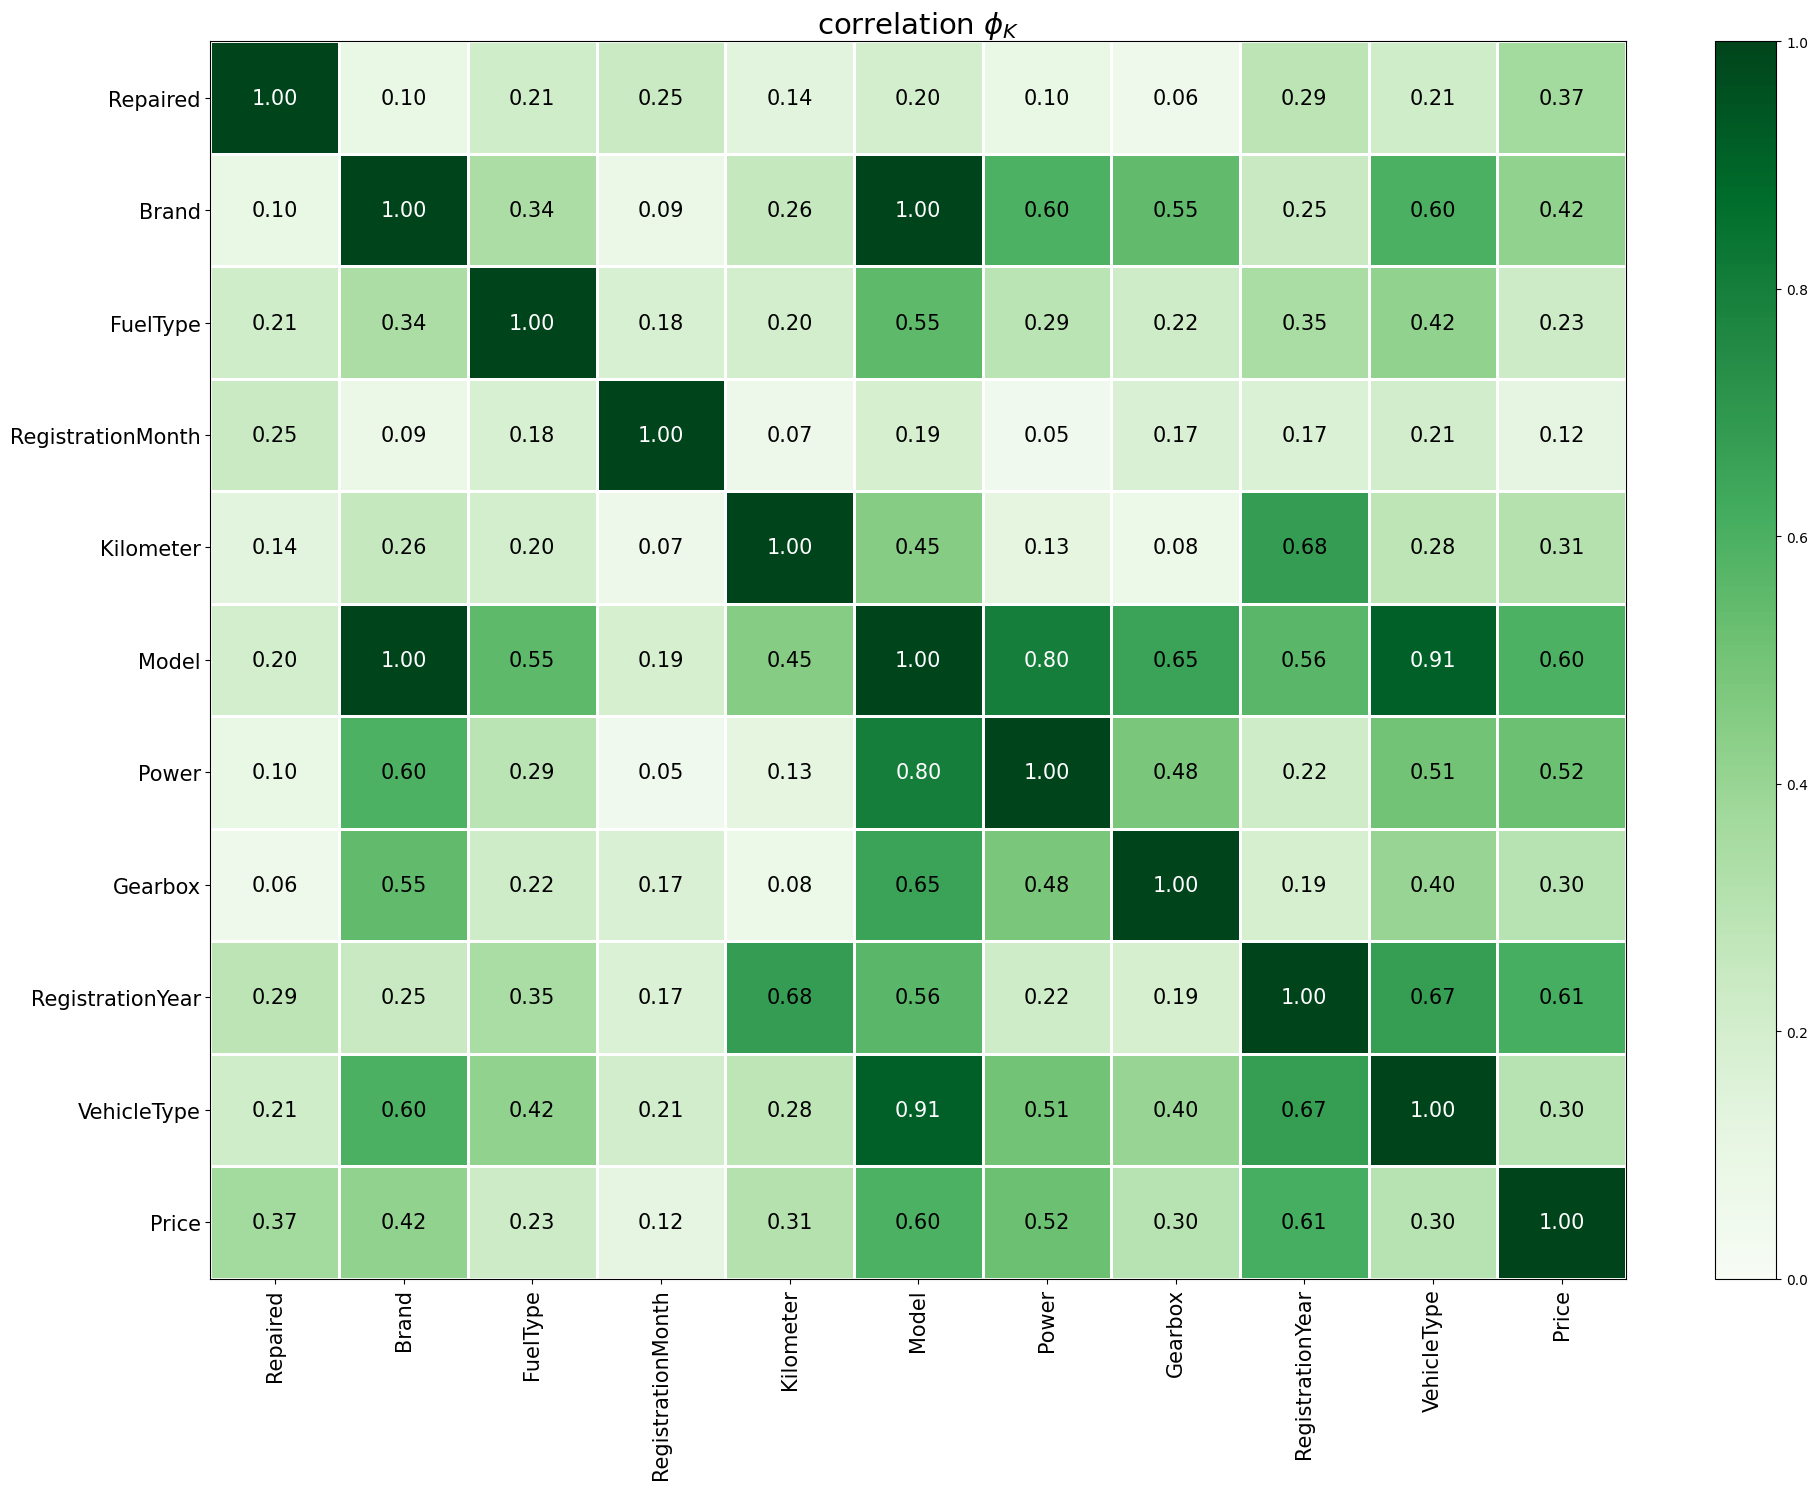

In [35]:
# Построим матрицу `phik`
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Матрица `phik` показывает, что зависимость между признаками `Brand` и `Model` функциональная (коэффициент корреляции `phik` равен 1,0). Кроме того, очень сильная корреляция между признаками `Model` и `VehicleType` (коэффициент корреляции 0,91). Можно сделать вывод, что имеется мультиколлинеарность, что будет мешать нашему исследованию. Однако удалять такие важные признаки нельзя. Объединим признаки `Brand` и `Model` в один признак, это по логике это будет один из самых важных признаков, характеризующих автомобиль.

In [36]:
autos_new['BrandModel'] = autos_new['Brand'] + '_'+ autos_new['Model']
autos_n = autos_new.drop(['Brand', 'Model'], axis=1)
autos_n.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Repaired,BrandModel
0,18300,coupe,2011,manual,190,125000,5,gasoline,yes,audi_unknown
1,9800,suv,2004,auto,163,125000,8,gasoline,yes,jeep_grand
2,1500,small,2001,manual,75,150000,6,petrol,no,volkswagen_golf
3,3600,small,2008,manual,69,90000,7,gasoline,no,skoda_fabia
4,2200,convertible,2004,manual,109,150000,8,petrol,no,peugeot_2_reihe


In [37]:
phik_overview_n = autos_n.phik_matrix(interval_cols=interval_cols)
print(phik_overview_n.shape)

(10, 10)


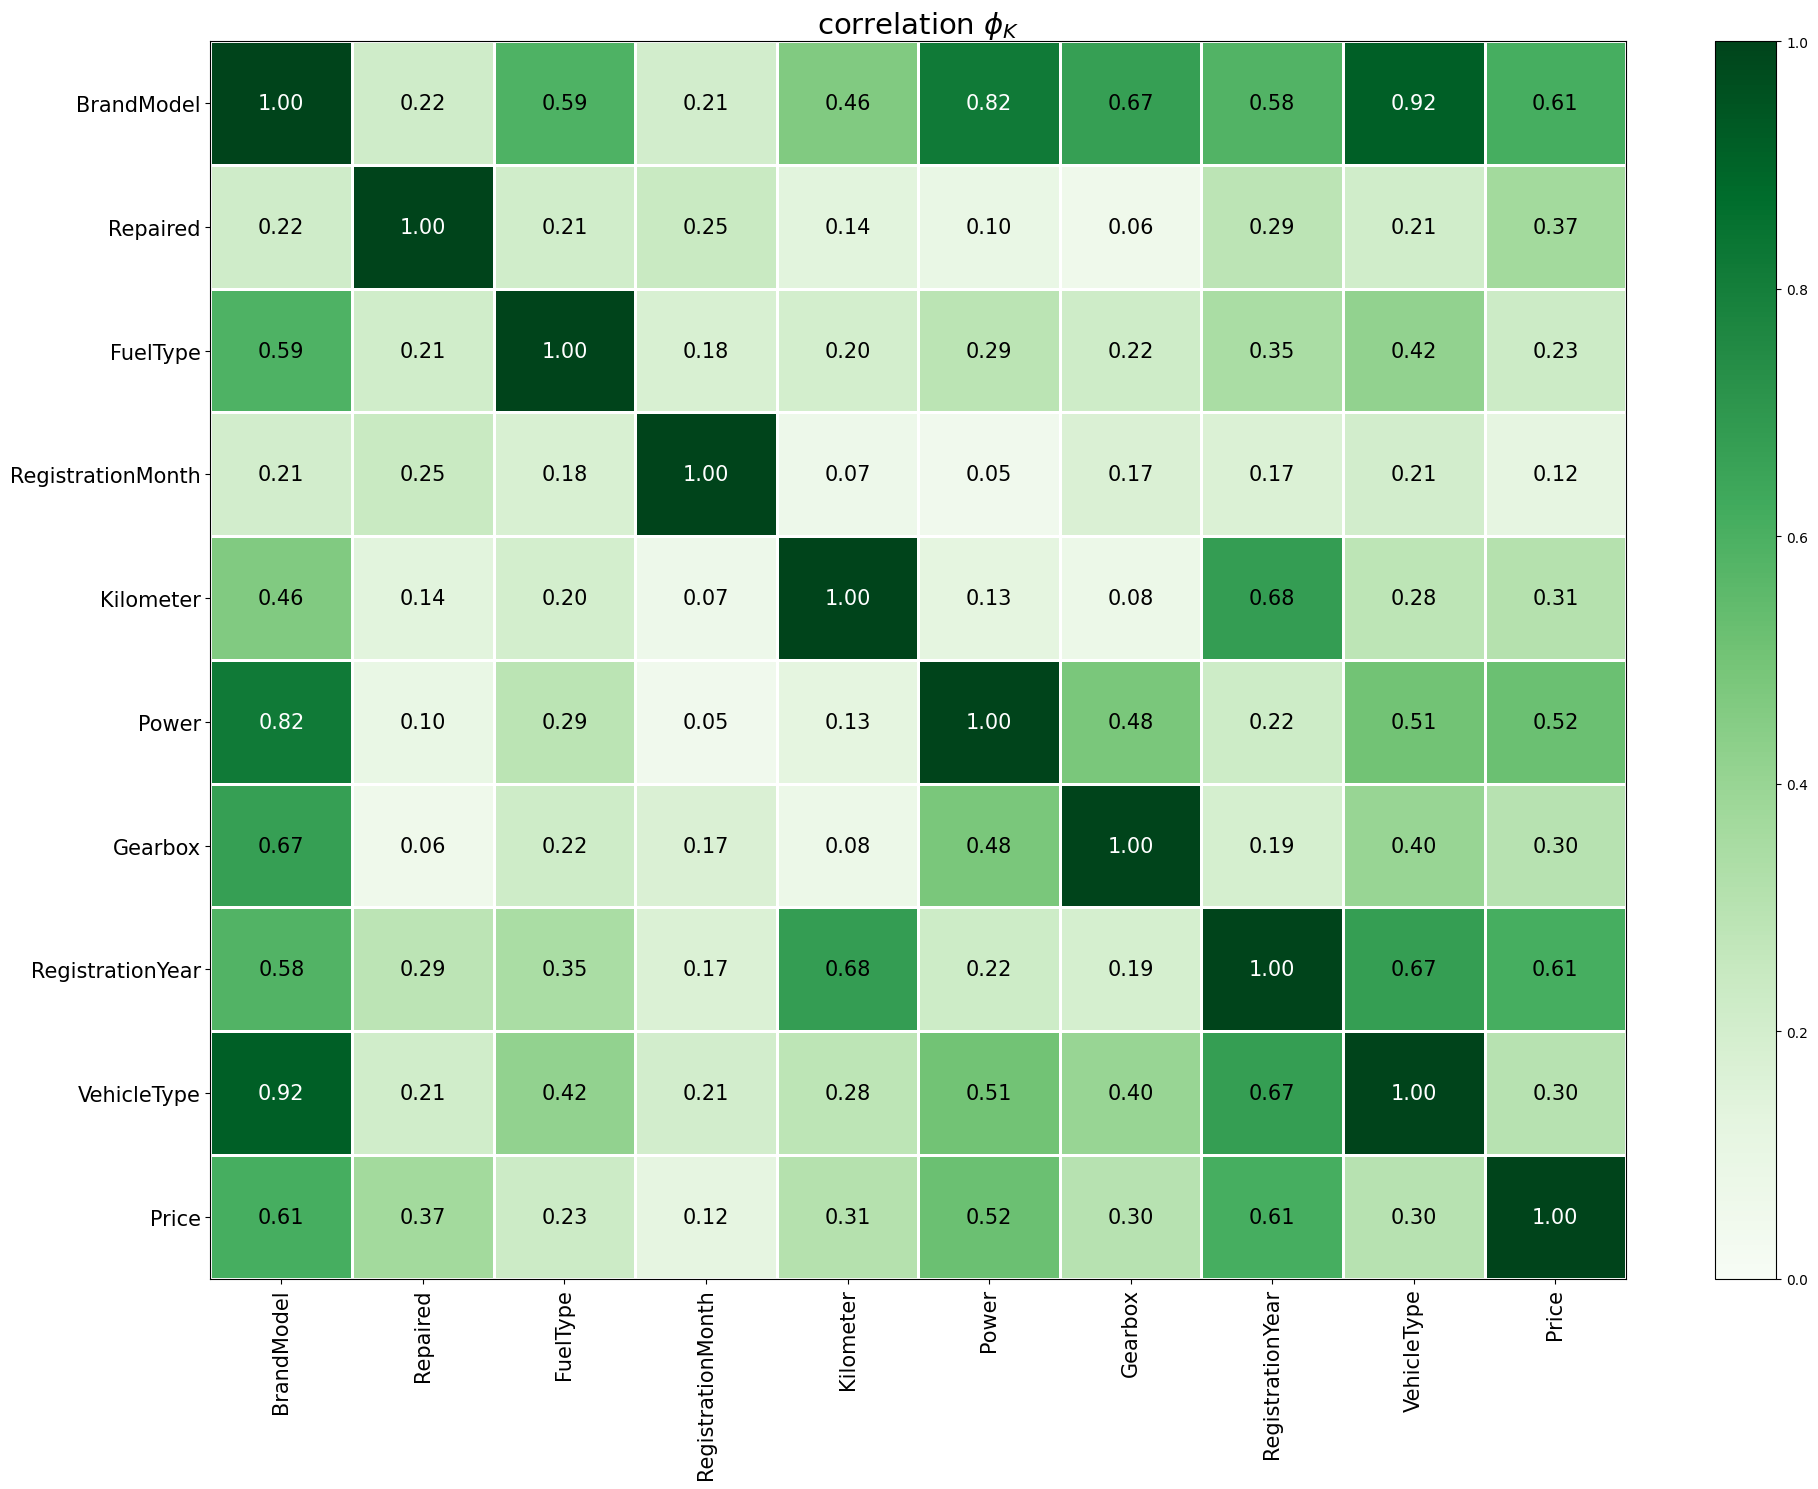

In [38]:
# Построим матрицу `phik`
plot_correlation_matrix(
    phik_overview_n.values,
    x_labels=phik_overview_n.columns,
    y_labels=phik_overview_n.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Итак, у целевого признака `Price` самая сильная связь отмечается с признаками `RegistrationYear`, `BrandModel` и `Power` (коэффициенты корреляции `phik` соответственно 0,61, 0,61 и 0,52). Признак `Repaired` также показывает заметную зависимость с целевым признаком (коэффициент 0,37). Другие признаки имеют меньшее влияние на целевой признак. Самый незначительный признак - `RegistrationMonth` (коэффициент корреляции 0,12). Мультиколлинеарность исключена.  

Признаки `RegistrationYear`, `Power`, `Kilometer`, `RegistrationMonth` - количественные, их будем масштабировать.
Признаки `VehicleType`, `Gearbox`, `FuelType`, `Repaired`, `BrandModel` - категориальные, их будем кодировать.  

В данном случае, когда целевой признак принимает непрерывное количественное значение, то есть стоит задача регрессии, дисбаланс классов не является проблемой.  

Датафрейм, подготовленный для исследования `autos_n`.

### Подготовка выборок

Разделим данные на тренировочную, валидационную и тестовую выборки, обозначим категориальные и количественные признаки.

Количество уникальных значений в категориальных признаках: 
VehicleType      9
Gearbox          3
FuelType         8
Repaired         2
BrandModel     324
dtype: int64


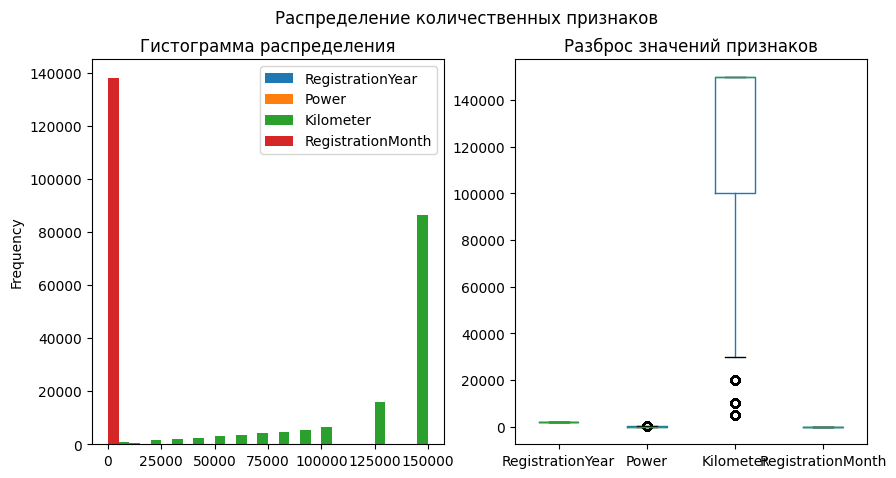

In [39]:
# Зададим константы
RANDOM_STATE=42

# Разделим данные на тренировочную, валидационную и тестовую выборки
X_train, X_test_valid, y_train, y_test_valid = train_test_split(
    autos_n.drop(['Price'], axis=1),
    autos_n['Price'],
    test_size=0.4,
    random_state=RANDOM_STATE
)

X_test, X_valid, y_test, y_valid = train_test_split(
    X_test_valid,
    y_test_valid,
    test_size=0.5,
    random_state=RANDOM_STATE
)

# Составим списки категориальных и количественных столбцов
cat_col_names = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'BrandModel']
num_col_names = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

# Проверим категориальные признаки
print(f'Количество уникальных значений в категориальных признаках: \n{X_train[cat_col_names].nunique()}')

# Проверим количественные признаки тренировочного датасета
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle('Распределение количественных признаков')
X_train[num_col_names].plot(kind='hist', bins=30, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box', ax=axes[1])
axes[1].set_title('Разброс значений признаков')
plt.show()

In [40]:
# Выведем размер выборок
print(
    "Размеры Train/Valid/Test: ",
    X_train.shape,
    X_valid.shape,
    X_test.shape,
    y_train.shape,
    y_valid.shape,
    y_test.shape
)

Размеры Train/Valid/Test:  (138296, 9) (46099, 9) (46099, 9) (138296,) (46099,) (46099,)


Количественные признаки для линейной регрессии необходимо масштабировать, это видно на графике. Категориальные признаки  нужно кодировать в зависимости от выбранных моделей.

Итак, мы разделили признаки на входные и целевой, одновременно разделили данные на тренировочную, валидационную и тестовую выборки.

## Обучение моделей
Обучим несколько моделей: модель линейной регрессии `LinearRegression()`, модель дерева решений `DecisionTreeRegressor`, модель градиентного бустинга `LightGBM`. Для некоторых моделей попробуем разные гиперпараметры. Для оценки качества моделей применим метрику `RMSE`, она удобна для сравнения качества модели по мере её настройки, её результаты легко интерпретировать.  

Разные модели требуют разной подготовки данных.  
Линейные модели требуют только числовые признаки, поэтому все категориальные признаки необходимо кодировать с помощью `OneHotEncoder`. Количественные признаки необходимо масштабировать.  
Для моделей на деревьях применяют кодирование с помощью `OrdinalEncoder`, чтобы не увеличивать чрезмерно количество признаков. Масштабирование количественных признаков не требуется.  
Выборку с помощью `OrdinalEncoder` допустимо применять и для бустинговых моделей, но модель `LightGBM`, которую мы будем использовать, умеет работать с данными как есть, сырые данные для них можно не категоризовать. В случае `LightGBM` можно привести эти категориальные признаки к типу `category`, тогда модель будет работать с категориальными признаками автоматически. Масштабировать количественные признаки не нужно.

### Модель LinearRegression

In [41]:
# Кодирование категориальных признаков
ohe_encoder = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist')
X_train_ohe = ohe_encoder.fit_transform(X_train[cat_col_names])
X_valid_ohe = ohe_encoder.transform(X_valid[cat_col_names]) 
X_test_ohe = ohe_encoder.transform(X_test[cat_col_names])
encoder_col_names = ohe_encoder.get_feature_names_out()

# Масштабирование количественных признаков
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_valid_scaled = scaler.transform(X_valid[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

# Создаём датафреймы из кодированных и масштабированных данных
X_train_ohe = X_train_ohe.toarray()
X_valid_ohe = X_valid_ohe.toarray()
X_test_ohe = X_test_ohe.toarray()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_valid_ohe = pd.DataFrame(X_valid_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    
# Объединение датафреймов
X_train_1 = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_valid_1 = pd.concat([X_valid_ohe, X_valid_scaled], axis=1)
X_test_1 = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [42]:
# Выведем размеры готовых выборок
print(
    "Размеры Train/Valid/Test: ",
    X_train_1.shape,
    X_valid_1.shape,
    X_test_1.shape,
    y_train.shape,
    y_valid.shape,
    y_test.shape
)

Размеры Train/Valid/Test:  (138296, 345) (46099, 345) (46099, 345) (138296,) (46099,) (46099,)


Категориальные признаки закодированы с помощью `OneHotEncoder()`, количественные признаки масштабированы с помощью `MinMaxScaler()`. Готовые выборки `X_train_1`, `X_valid_1`, `X_test_1`, `y_train`, `y_valid`, `y_test`.

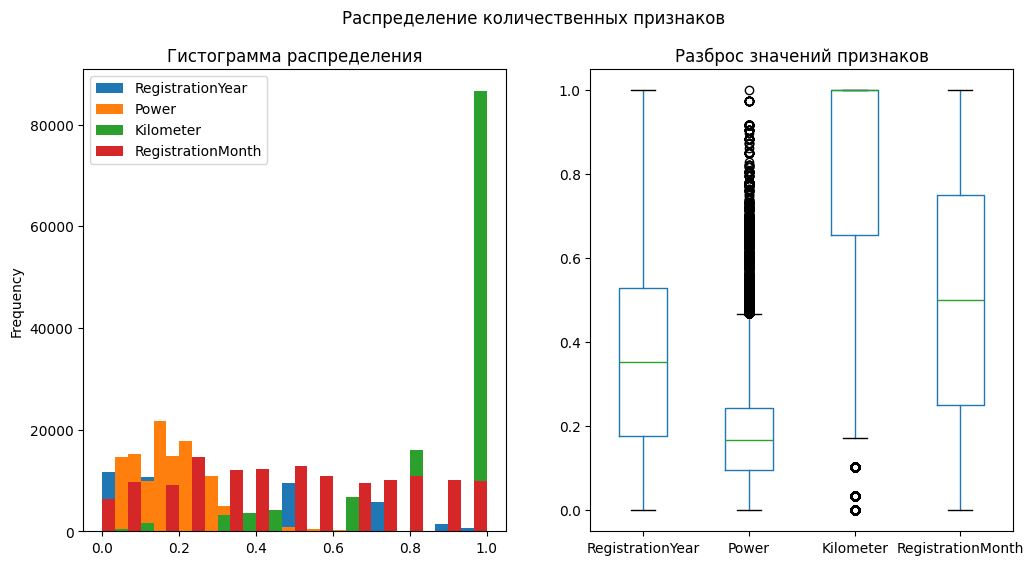

In [43]:
# Построим графики для количественных признаков тренировочного датасета после масштабирования
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Распределение количественных признаков')
X_train_scaled.plot(kind='hist', bins=30, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train_scaled.plot(kind='box', ax=axes[1])
axes[1].set_title('Разброс значений признаков')
plt.show()

Масштабирование количественных признаков и кодирование категориальных признаков прошло успешно.  

Обучим модель линейной регрессии. Измерим время обучения, время предсказания и посчитаем метрику `RMSE`.

In [44]:
# Запускаем таймер
start = time.time()

# Инициализация и обучение модели 'LinearRegression()'
model_lr = LinearRegression()
model_lr.fit(X_train_1, y_train)

# Считаем, сколько времени прошло с начала запуска
learn_time_lr = round(time.time() - start, 3)

# Выводим на экран время обучения
print(f'Время обучения модели lr: {learn_time_lr}')

Время обучения модели lr: 3.151


In [45]:
# Запускаем таймер
start = time.time()

# Предсказания значений для X_valid
pred_lr = model_lr.predict(X_valid_1)

# Считаем, сколько времени прошло с начала запуска
predict_time_lr = round(time.time() - start, 3)

# Выводим на экран время обучения
print(f'Время предсказания модели lr: {predict_time_lr}')

Время предсказания модели lr: 0.106


In [46]:
# Получение значения RMSE с параметрами модели
rmse_lr = round(mean_squared_error(y_valid, pred_lr, squared=False), 2)
print(f'RMSE модели lr: {rmse_lr}')

RMSE модели lr: 2265.34


Модель `LinearRegression()` показала время обучения 3.151 секунды, время предсказания 0,106 секунды, метрика RMSE имеет значение 2265.34 евро. Это хорошее значение метрики, но время обучения достаточно велико.

### Модель DecisionTreeRegressor

In [47]:
# Создадим копии выборок для модели дерева решений
X_train_2 = X_train.copy()
X_valid_2 = X_valid.copy()
X_test_2 = X_test.copy()

# Кодирование категориальных признаков
ord_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1
)
X_train_2[cat_col_names] = ord_encoder.fit_transform(X_train_2[cat_col_names])
X_valid_2[cat_col_names] = ord_encoder.transform(X_valid_2[cat_col_names]) 
X_test_2[cat_col_names] = ord_encoder.transform(X_test_2[cat_col_names])

In [48]:
# Выведем размеры готовых выборок
print(
    "Размеры Train/Valid/Test: ",
    X_train_2.shape,
    X_valid_2.shape,
    X_test_2.shape,
    y_train.shape,
    y_valid.shape,
    y_test.shape
)

Размеры Train/Valid/Test:  (138296, 9) (46099, 9) (46099, 9) (138296,) (46099,) (46099,)


Категориальные признаки закодированы с помощью `OrdinalEncoder()`, количественные признаки оставлены как есть. Готовые выборки `X_train_2`, `X_valid_2`, `X_test_2`, `y_train`, `y_valid`, `y_test`.

In [49]:
# Инициализация и обучение модели с гиперпараметрами по умолчанию
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)
model_dtr.fit(X_train_2, y_train)

# Предсказания значений для X_valid
pred_dtr = model_dtr.predict(X_valid_2)

# Получение значения RMSE с параметрами модели по умолчанию
rmse_dtr = mean_squared_error(y_valid, pred_dtr, squared=False)
print(f'RMSE модели dtr: {round(rmse_dtr, 2)}')

RMSE модели dtr: 2078.45


In [50]:
# Попробуем подобрать гиперпараметры для модели DecisionTreeRegressor()
# Инициализация и обучение модели с новыми гиперпараметрами (вариант 1)
model_dtr_1 = DecisionTreeRegressor(
    max_depth=2,
    min_samples_split=3,
    min_samples_leaf=2,
    max_leaf_nodes=50,
    random_state=RANDOM_STATE)
model_dtr_1.fit(X_train_2, y_train)

pred_dtr_1 = model_dtr_1.predict(X_valid_2)

rmse_dtr_1 = mean_squared_error(y_valid, pred_dtr_1, squared=False)
print(f'RMSE модели dtr_1: {round(rmse_dtr_1, 2)}')

RMSE модели dtr_1: 3315.51


In [51]:
# Инициализация и обучение модели с новыми гиперпараметрами (вариант 2)
model_dtr_2 = DecisionTreeRegressor(
    max_depth=3,
    min_samples_split=4,
    min_samples_leaf=3,
    max_leaf_nodes=80,
    random_state=RANDOM_STATE)
model_dtr_2.fit(X_train_2, y_train)

pred_dtr_2 = model_dtr_2.predict(X_valid_2)

rmse_dtr_2 = mean_squared_error(y_valid, pred_dtr_2, squared=False)
print(f'RMSE модели dtr_2: {round(rmse_dtr_2, 2)}')

RMSE модели dtr_2: 3015.9


In [52]:
# Инициализация и обучение модели с новыми гиперпараметрами (вариант 3)
model_dtr_3 = DecisionTreeRegressor(
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=3,
    max_leaf_nodes=60,
    random_state=RANDOM_STATE)
model_dtr_3.fit(X_train_2, y_train)

pred_dtr_3 = model_dtr_3.predict(X_valid_2)

rmse_dtr_3 = mean_squared_error(y_valid, pred_dtr_3, squared=False)
print(f'RMSE модели dtr_3: {round(rmse_dtr_3, 2)}')

RMSE модели dtr_3: 2249.29


In [53]:
# Инициализация и обучение модели с новыми гиперпараметрами (вариант 4)
model_dtr_4 = DecisionTreeRegressor(
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=6,
    max_leaf_nodes=None,
    random_state=RANDOM_STATE)
model_dtr_4.fit(X_train_2, y_train)

pred_dtr_4 = model_dtr_4.predict(X_valid_2)

rmse_dtr_4 = mean_squared_error(y_valid, pred_dtr_4, squared=False)
print(f'RMSE модели dtr_4: {round(rmse_dtr_4, 2)}')

RMSE модели dtr_4: 1794.99


Лучшие гиперпараметры у модели `DecisionTreeRegressor`: `min_samples_split` = 5, `min_samples_leaf` = 6. Инициализируем модель с такими гиперпараметрами и выведем время обучения, время прогноза и метрику `RMSE`.

In [54]:
# Измеряем время обучения модели 'DecisionTreeRegressor()'
# Запускаем таймер
start = time.time()

# Инициализируем модель с нужными гиперпараметрами
model_dtr_best = DecisionTreeRegressor(
    min_samples_split=5,
    min_samples_leaf=6,
    random_state=RANDOM_STATE)

model_dtr_best.fit(X_train_2, y_train)

# Считаем, сколько времени прошло с начала запуска
learn_time_dtr = round(time.time() - start, 3)

# Выводим на экран время работы
print(f'Время обучения модели dtr: {learn_time_dtr}')

Время обучения модели dtr: 0.339


In [55]:
# Измеряем время предсказания модели 'DecisionTreeRegressor()'
# Запускаем таймер
start = time.time()

pred_dtr_best = model_dtr_best.predict(X_valid_2)

# Считаем, сколько времени прошло с начала запуска
predict_time_dtr = round(time.time() - start, 3)

# Выводи на экран время работы
print(f'Время предсказания модели dtr: {predict_time_dtr}')

Время предсказания модели dtr: 0.015


In [56]:
# Ещё раз получим значение RMSE модели 'DecisionTreeRegressor()' с лучшими гиперпараметрами 
rmse_dtr_best = round(mean_squared_error(y_valid, pred_dtr_best, squared=False), 2)
print(f'RMSE модели dtr с лучшими гиперпараметрами: {rmse_dtr_best}')

RMSE модели dtr с лучшими гиперпараметрами: 1794.99


Модель `DecisionTreeRegressor()` с лучшими гиперпараметрами `min_samples_split` = 5, `min_samples_leaf` = 6 показала время обучения 0,339 секунды, время предсказания 0,015 секунды, метрика `RMSE` имеет значение 1794,99 евро. Это очень хорошее значение.

### Модель LGBMRegressor

Категориальные признаки не закодированы, количественные признаки не масштабированы. Готовые выборки `X_train`, `X_valid`, `X_test`, `y_train`, `y_valid`, `y_test`.

In [57]:
# Переведём категориальные признаки в тип данных 'category'
X_train_3 = X_train.copy()
X_valid_3 = X_valid.copy()
X_test_3 = X_test.copy()
X_train_3[cat_col_names] = X_train_3[cat_col_names].astype('category')
X_valid_3[cat_col_names] = X_valid_3[cat_col_names].astype('category')
X_test_3[cat_col_names] = X_test_3[cat_col_names].astype('category')

# Проверим на примере тренировочной выборки
print(X_train_3.dtypes)

VehicleType          category
RegistrationYear        int64
Gearbox              category
Power                   int64
Kilometer               int64
RegistrationMonth       int64
FuelType             category
Repaired             category
BrandModel           category
dtype: object


Используем для обучения модели `LGBMRegressor()` некодированные и немасштабированные признаки. Готовые выборки `X_train_3`, `X_valid_3`, `X_test_3`, `y_train`, `y_valid`, `y_test`.

In [58]:
# Инициализация и обучение модели с гиперпараметрами по умолчанию
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)
model_lgbm.fit(X_train_3, y_train)

# Предсказания значений для X_valid
pred_lgbm = model_lgbm.predict(X_valid_3)

# Получение значения RMSE с параметрами модели по умолчанию
rmse_lgbm = mean_squared_error(y_valid, pred_lgbm, squared=False)
print('-' * 40)
print(f'RMSE модели lgbm: {round(rmse_lgbm, 2)}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 138296, number of used features: 9
[LightGBM] [Info] Start training from score 5655.749870
----------------------------------------
RMSE модели lgbm: 1589.99


Попробуем перебрать гиперпараметры. Бустинговая модель может работать очень долго, поэтому попробуем изменить только два гиперпараметра. Обучим модель `LGBMRegressor()` с изменёнными гиперпараметрами.

In [59]:
# Инициализация, обучение, прогноз и метрика модели с изменёнными гиперпараметрами (вариант 1)
model_lgbm_1 = LGBMRegressor(
    n_estimators=150,
    max_depth=10,
    random_state=RANDOM_STATE)
model_lgbm_1.fit(X_train_3,y_train)

pred_lgbm_1 = model_lgbm_1.predict(X_valid_3)

rmse_lgbm_1 = mean_squared_error(y_valid, pred_lgbm_1, squared=False)
print('-' * 40)
print(f'RMSE модели lgbm_1: {round(rmse_lgbm_1, 2)}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 138296, number of used features: 9
[LightGBM] [Info] Start training from score 5655.749870
----------------------------------------
RMSE модели lgbm_1: 1572.26


Попробуем предложить модели `LGBMRegressor` ещё несколько вариантов изменённых гиперпараметров.

In [60]:
# Инициализация, обучение, прогноз и метрика модели с изменёнными гиперпараметрами (вариант 2)
model_lgbm_2 = LGBMRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=RANDOM_STATE)
model_lgbm_2.fit(X_train_3,y_train)

pred_lgbm_2 = model_lgbm_2.predict(X_valid_3)

rmse_lgbm_2 = mean_squared_error(y_valid, pred_lgbm_2, squared=False)
print('-' * 40)
print(f'RMSE модели lgbm_2: {round(rmse_lgbm_2, 2)}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 138296, number of used features: 9
[LightGBM] [Info] Start training from score 5655.749870
----------------------------------------
RMSE модели lgbm_2: 1557.98


In [61]:
# Инициализация, обучение, прогноз и метрика модели с изменёнными гиперпараметрами (вариант 3)
model_lgbm_3 = LGBMRegressor(
    n_estimators=300,
    num_leaves=100,
    max_depth=200,
    random_state=RANDOM_STATE)
model_lgbm_3.fit(X_train_3, y_train)

pred_lgbm_3 = model_lgbm_3.predict(X_valid_3)

rmse_lgbm_3 = mean_squared_error(y_valid, pred_lgbm_3, squared=False)
print('-' * 40)
print(f'RMSE модели lgbm_3: {round(rmse_lgbm_3, 2)}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 138296, number of used features: 9
[LightGBM] [Info] Start training from score 5655.749870
----------------------------------------
RMSE модели lgbm_3: 1512.75


Итак, лучшая модель `LGBMRegressor()` имеет гиперпараметры `n_estimators` = 300, `num_leaves` = 100, `max_depth` = 200, значение RMSE 1512.75 евро. Измерим время её обучения и время прогнозирования.

In [62]:
# Измеряем время обучения модели 'LGBMRegressor()'
# Запускаем таймер
start = time.time()

# Инициализируем модель с нужными гиперпараметрами
model_lgbm_best = LGBMRegressor(
    n_estimators=300,
    num_leaves=100,
    max_depth=200,
    random_state=RANDOM_STATE)

model_lgbm_best.fit(X_train_3, y_train)

# Считаем, сколько времени прошло с начала запуска
learn_time_lgbm = round(time.time() - start, 3)

# Выводи на экран время работы
print('-' * 40)
print(f'Время обучения модели lgbm: {learn_time_lgbm}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 138296, number of used features: 9
[LightGBM] [Info] Start training from score 5655.749870
----------------------------------------
Время обучения модели lgbm: 1.831


In [63]:
# Измеряем время предсказания модели
# Запускаем таймер
start = time.time()

pred_lgbm_best = model_lgbm_best.predict(X_valid_3)

# Считаем, сколько времени прошло с начала запуска
predict_time_lgbm = round(time.time() - start, 3)

# Выводим на экран время работы
print(f'Время предсказания модели lgbm: {predict_time_lgbm}')

Время предсказания модели lgbm: 0.537


In [64]:
# Ещё раз получим значение RMSE модели 'LGBMRegressor()' с лучшими гиперпараметрами 
rmse_lgbm_best = round(mean_squared_error(y_valid, pred_lgbm_best, squared=False), 2)
print(f'RMSE модели lgbm с лучшими гиперпараметрами: {rmse_lgbm_best}')

RMSE модели lgbm с лучшими гиперпараметрами: 1512.75


Модель `LGBMRegressor()` с лучшими гиперпараметрами `n_estimators` = 300, `num_leaves` = 100, `max_depth` = 200 показала время обучения 1.831 секунды, время предсказания 0,537 секунды, метрика `RMSE` имеет значение 1512.75 евро. Это очень хорошее значение.

## Анализ моделей

In [65]:
# Создадим списки
# лучших моделей
models = ['LinearRegression()', 'DecisionTreeRegressor()', 'LGBMRegressor()']

# лучших гиперпараметров
parameters = ['Nan', 'min_samples_split=5, min_samples_leaf=6', 'n_estimators=300, num_leaves=100, max_depth=200']

# соответствующих значений времени обучения
learn_time = [learn_time_lr, learn_time_dtr, learn_time_lgbm]

# соответствующих значений времени прогнозирования
predict_time = [predict_time_lr, predict_time_dtr, predict_time_lgbm]

# соответствующих значений метрики `RMSE`
rmse_metrics = [rmse_lr, rmse_dtr_best, rmse_lgbm_best]

# Выведем получившиеся списки
print(models)
print(parameters)
print(learn_time)
print(predict_time)
print(rmse_metrics)

['LinearRegression()', 'DecisionTreeRegressor()', 'LGBMRegressor()']
['Nan', 'min_samples_split=5, min_samples_leaf=6', 'n_estimators=300, num_leaves=100, max_depth=200']
[3.151, 0.339, 1.831]
[0.106, 0.015, 0.537]
[2265.34, 1794.99, 1512.75]


In [66]:
# Для наглядности создадим таблицу с итоговыми значениями
# создадим список списков
results = []
results.append(models)
results.append(parameters)
results.append(learn_time)
results.append(predict_time)
results.append(rmse_metrics)

# Конвертируем список списков в датафрейм
results_df = pd.DataFrame(results).transpose()
results_df.columns =['models', 'parameters', 'learn_time', 'predict_time', 'rmse_metrics']

# Выводим итоговую таблицу
results_df

,models,parameters,learn_time,predict_time,rmse_metrics
0,LinearRegression(),Nan,3.151,0.106,2265.34
1,DecisionTreeRegressor(),"min_samples_split=5, min_samples_leaf=6",0.339,0.015,1794.99
2,LGBMRegressor(),"n_estimators=300, num_leaves=100, max_depth=200",1.831,0.537,1512.75


Самая плохая метрика `RMSE` у модели `LinearRegression()`. Эту модель отбрасываем. Из двух других моделей метрика `RMSE` чуть выше у бустинговой модели `LGBMRegressor()`. Однако время её обучения и время прогноза в несколько раз выше, чем у дерева решений. А для заказчика важна не только метрика, но и скорость работы модели. У модели `DecisionTreeRegressor()` скорость работы самая высокая, и метрика `RMSE` хорошая, её значение на валидационных данных 1794,99 евро.  

Протестируем эту модель на тестовой выборке, рассчитаем финальную метрику `RMSE`.

In [67]:
# Предсказания по выбранной модели на тестовой выборке
pred_dtr_fin = model_dtr_best.predict(X_test_2)

# Получим значение модели на тестовой выборке 
rmse_dtr_fin = round(mean_squared_error(y_test, pred_dtr_fin, squared=False), 2)
print(f'RMSE модели dtr с лучшими гиперпараметрами: {rmse_dtr_fin}')

RMSE модели dtr с лучшими гиперпараметрами: 1819.83


Финальная метрика выбранной модели хорошая, и она ненамного отличается от метрики на валидационных данных.

# Вывод

Перед нами стояла задача построить модель, которая умеет определять рыночную стоимость автомобиля на основе данных о технических характеристиках, комплектации и ценах других автомобилей. На основе этой модели будет разработано приложение для сервиса по продаже автомобилей с пробегом "Не бит, не крашен" с целью привлечения новых клиентов.

Для определения рыночной стоимости автомобиля выбираем модель `DecisionTreeRegressor()` с гиперпараметрами min_samples_split=5, min_samples_leaf=6. Она обучается за 0,339 секунды, предсказывает за 0,015 секунды. В среднем модель ошибается на 1820 евро. Это хорошая точность предсказания.